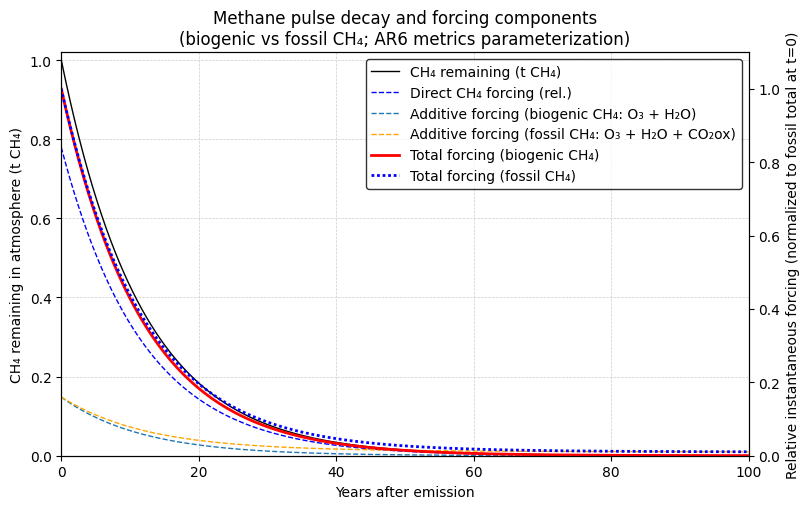

Calibrated oxidation-CO₂ scaling factor k_co2ox = 0.03061378262637276


In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "text.color": "black",
    "grid.color": "0.8",
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
})
# --- Parameters (AR6 metrics module) ---
tau_ch4 = 11.8  # CH4 lifetime [years]
f_ch4_o3  = 0.29
f_ch4_h2o = -0.10

# Fossil CH4 includes additional CO2 from oxidation in many accounting frameworks.
# We represent this as a long tail using a CO2 impulse response function (IRF).
include_ox_co2 = True

# --- Time grid ---
t = np.linspace(0, 100, 2001)

# --- CH4 pulse (1 t CH4) remaining in atmosphere ---
E_ch4 = 1.0  # t CH4 pulse
ch4_mass = E_ch4 * np.exp(-t / tau_ch4)

# --- Forcing decomposition (biogenic) ---
F_direct = np.exp(-t / tau_ch4)
F_total_bio  = (1 + f_ch4_o3 + f_ch4_h2o) * F_direct
F_add_bio    = F_total_bio - F_direct

# --- Oxidation CO2 tail (fossil only) ---
# CO2 IRF (Joos-style; used in IPCC metric work)
a0, a1, a2, a3 = 0.2173, 0.2240, 0.2824, 0.2763
t1, t2, t3 = 394.4, 36.54, 4.304
co2_irf = a0 + a1*np.exp(-t/t1) + a2*np.exp(-t/t2) + a3*np.exp(-t/t3)

# Scale oxidation CO2 tail so that fossil/non-fossil GWP100 ratio matches AR6 split
gwp100_nonfossil = 27.2
gwp100_fossil    = 29.8
target_ratio = gwp100_fossil / gwp100_nonfossil

A = np.trapezoid(F_total_bio, t)
B = np.trapezoid((1 - F_direct) * co2_irf, t)
k_co2ox = (target_ratio * A - A) / B  # calibrated scaling factor

F_ox_co2 = k_co2ox * (1 - F_direct) * co2_irf if include_ox_co2 else 0.0

F_total_fos = F_total_bio + F_ox_co2
F_add_fos   = F_total_fos - F_direct

# --- Normalize forcing curves to fossil total at t=0 (for plotting) ---
norm = F_total_fos[0]
F_direct_n    = F_direct / norm
F_total_bio_n = F_total_bio / norm
F_total_fos_n = F_total_fos / norm
F_add_bio_n   = (F_total_bio - F_direct) / norm
F_add_fos_n   = (F_total_fos - F_direct) / norm

# --- Plot (dual y-axis) ---
fig, ax1 = plt.subplots(figsize=(8.2, 5.2))

# Left axis: CH4 mass remaining (same for fossil and biogenic)
ax1.plot(t, ch4_mass, color="black",linestyle="-", label="CH₄ remaining (t CH₄)", linewidth=1)
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 1.02)
ax1.set_xlabel("Years after emission")
ax1.set_ylabel("CH₄ remaining in atmosphere (t CH₄)")
ax1.grid(True, linestyle="--", linewidth=0.5)

# Right axis: forcing curves
ax2 = ax1.twinx()

ax2.plot(t, F_direct_n, color="blue", linestyle="--", linewidth=1, label="Direct CH₄ forcing (rel.)")
ax2.plot(t, F_add_bio_n, linestyle="--", linewidth=1, label="Additive forcing (biogenic CH₄: O₃ + H₂O)")
ax2.plot(t, F_add_fos_n, color="orange", linestyle="--", linewidth=1, label="Additive forcing (fossil CH₄: O₃ + H₂O + CO₂ox)")
ax2.plot(t, F_total_bio_n, color="red", linestyle="-", linewidth=2, label="Total forcing (biogenic CH₄)")
ax2.plot(t, F_total_fos_n, color="blue", linestyle=(0, (1, 1)), linewidth=2, label="Total forcing (fossil CH₄)")

ax2.set_ylim(0, 1.1)
ax2.set_ylabel("Relative instantaneous forcing (normalized to fossil total at t=0)")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right", frameon=True)

ax1.set_title("Methane pulse decay and forcing components\n(biogenic vs fossil CH₄; AR6 metrics parameterization)")
fig.tight_layout()
plt.show()

print("Calibrated oxidation-CO₂ scaling factor k_co2ox =", k_co2ox)
